# Assignment #8: Modeling, Simulation, and Analysis of Rigid Body Motion. 

* Save this file in your Institutional G-Suite google drive and rename it starting with your index number. For example if you are E/90/512 then rename the file to 
'E90512_xxxx.ipynb'

* Get started!

* Once complete share with smaithri@eng.pdn.ac.lk and chanakatb@eng.pdn.ac.lk

* Submit the link at the end of 'Lesson on Modeling, Simulation, and Analysis of Rigid Body Motion'

* Upload the file through the Assignment Submission Link at the end of the Lesson.

# Setting up Python 

In [1]:
import math
import numpy as np
from numpy import linalg
from scipy.integrate import odeint
import plotly.graph_objects as go

from sympy import symbols
from sympy import *

from sympy.physics.mechanics import dynamicsymbols, init_vprinting

In [2]:
class mugas_rigid_body_functions:
  
  def __init__(self): 
    self=[];

  def simulateDySystem(self, dynamicSystemModel, Tmax, dT, X0, sysPara, figTitle, xLabel, yLabel):
    t = np.linspace(0, Tmax, int(Tmax/dT+1))
    sol = odeint(dynamicSystemModel, X0, t, args=(sysPara,));
    self.soln=sol;
    fig = go.Figure()
    [nt,nS]=sol.shape;

    # Add traces
    for nn in range(nS):
      fig.add_trace(go.Scatter(x=t, y=sol[:,nn], mode='lines+markers', name='x'+str(nn+1)))
      fig.update_layout(title=figTitle, xaxis=dict(title=xLabel),yaxis=dict(title=yLabel))
    
    fig.show()
    return [t,sol,fig] 

  def hatMatrix(self, X):
    return np.array([[0., -X[2], X[1]],[X[2], 0., -X[0]],[-X[1], X[0], 0.]])

  def qFromAxisAngles(self, theta, unitAxis):
    return np.concatenate(([np.cos(theta/2)],np.sin(theta/2)*np.array(unitAxis)))

  def RfromQuaternions(self,q):
    q0=q[0]; w=q[1:];
    R=np.identity(3)+2*q0*self.hatMatrix(w)+2*self.hatMatrix(w) @ self.hatMatrix(w);
    return R

  def rotationMatrix2EulerAngles(self,R):
    if R[2,2] <1:
      if R[2,2] > -1:
        theta2=math.acos(R[2,2]);
        theta1=math.atan2(R[0,2],R[1,2]);
        theta3=math.atan2(R[2,0],-R[2,1]);
      else: #R[2,2]=-1 No Unique solution 
        theta2=np.pi;
        theta1=-math.atan2(R[0,1],-R[0,0]);
        theta3=0;
    else: # R[2,2] = +1 No Unique solution
      theta2 = 0;
      theta1 = math.atan2(R[0,1],R[0,0]) ;
      theta3 = 0;
    return [np.pi-theta1,theta2,np.pi-theta3]

  def Re3equalsgamma(self,gamma):
    theta=math.acos(gamma[2]);
    n1=-gamma[1]/np.sin(theta);
    n2=gamma[0]/np.sin(theta);
    q00=self.qFromAxisAngles(theta,[n1,n2,0]);

    return self.RfromQuaternions(q00)

  def rotate_and_translate(self,objectVertices,R,b):
    #object vertices should be given as an numpy array of shape (3,n) 
    #Ex - X=[0, 0, 2, 2, 0, 0, 2, 2], Y=[0, 2, 2, 0, 0, 2, 2, 0], Z=[0, 0, 0, 0, 1, 1, 1, 1]; objectVertices=[X,Y,Z]
    return np.array([[b[0],b[1],b[2]]]).T + R @ objectVertices



  def addOrthNormFrame(self, fig, o, R, axisRange, axisColor):
    e1=[1,0,0]; e2=[0,1,0]; e3=[0,0,1];
    b1=R @ e1; b2=R @ e2; b3=R @ e3;
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b1[0])], y=[str(o[1]),str(o[1]+b1[1])], z=[str(o[2]),str(o[2]+b1[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b2[0])], y=[str(o[1]),str(o[1]+b2[1])], z=[str(o[2]),str(o[2]+b2[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b3[0])], y=[str(o[1]),str(o[1]+b3[1])], z=[str(o[2]),str(o[2]+b3[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.update_layout(showlegend=False, scene=dict(xaxis=dict(range=axisRange[0], autorange=False), yaxis=dict(range=axisRange[1], autorange=False), zaxis=dict(range=axisRange[2], autorange=False), aspectratio=dict(x=1, y=1, z=1)))
    return fig

  def cube_vertices(self,cubeDimensions):
    l=cubeDimensions['l']; w=cubeDimensions['w']; h=cubeDimensions['h'];
    xp=cubeDimensions['xp']; yp=cubeDimensions['yp']; zp=cubeDimensions['zp'];
    #X=[0, 0, l, l, 0, 0, l, l]; Y=[0, w, w, 0, 0, w, w, 0]; Z=[0, 0, 0, 0, h, h, h, h]; XX=[X,Y,Z];
    X=[-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]; Y=[-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]; Z=[-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]; XX=[X,Y,Z];
    #X=[-l, -l, l, l, -l, -l, l, l]; Y=[-w, w, w, -w, -w, w, w, -w]; Z=[-h, -h, -h, -h, h, h, h, h]; XX=[X,Y,Z]; 
    return XX


  def animate_particle_motion(self, XX, axisRange, figTitle):
    xx=[jj[0] for jj in XX]
    yy=[jj[1] for jj in XX]
    zz=[jj[2] for jj in XX]

    fig = go.Figure(
        data=[go.Scatter3d(x=[xx[0]], y=[yy[0]],z=[zz[0]],
                        mode="markers",
                        marker=dict(color="red", size=10)),
              go.Scatter3d(x=xx, y=yy,z=zz, name='Path',
                        mode="lines",
                        line=dict(color="blue", width=2))],
        layout=go.Layout(
            scene = dict(
                        xaxis=dict(range=axisRange[0], autorange=False),
                        yaxis=dict(range=axisRange[1], autorange=False),
                        zaxis=dict(range=axisRange[2], autorange=False),
                        aspectratio=dict(x=1, y=1, z=1),
            ),
            title_text=figTitle, hovermode="closest",
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]),
        frames=[go.Frame(
            data=[go.Scatter3d(
                x=[p[0]],
                y=[p[1]],
                z=[p[2]],
                name='Particle',
                mode="markers",
                marker=dict(color="red", size=10))])

            for p in XX]
    )

    fig.show()
    return fig

  def animated_cube_flat_shading(self, cubeVertices,figTitle):
    fig = go.Figure(
        frames=[go.Frame(data=[
          go.Mesh3d(
            # 8 vertices of a cube
            x=xx[0][0],
            y=xx[0][1],
            z=xx[0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)]) for xx in cubeVertices])

    fig.add_trace(go.Mesh3d(
            # 8 vertices of a cube
            x=cubeVertices[0][0][0],
            y=cubeVertices[0][0][1],
            z=cubeVertices[0][0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)
        )
    duration=10;
    fig.update_layout(
          title=figTitle,
          width=600,
          height=600,
          scene=dict(
                      xaxis=dict(range=[-5., 5.], autorange=False),
                      yaxis=dict(range=[-5., 5.], autorange=False),
                      zaxis=dict(range=[-5., 5.], autorange=False),
                      aspectratio=dict(x=1, y=1, z=1),
                      ),
          updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None, {"frame": {"duration": duration},"mode": "immediate","fromcurrent": True, "transition": {"duration": duration, "easing": "linear"},}]
                                            )])])
    len(fig.frames)
    fig.show()
    return fig
  
  def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
    XX=self.cube_vertices(cubeDimensions);
    
    #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
    Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);
    ICR=ICs[0][0];
    XX0=ICR @ XX;
    
    rotatedVertices=[[XX0]]
    for X in Xs:
      #print(X[0])
      R=X[0][0]; 
      o=X[0][1];
      XXi=self.rotate_and_translate(XX,R,o);
      XX0=XXi;
      rotatedVertices+=[[XX0]];
    return rotatedVertices


  def eulers_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      [taue,fe]=externalForceModel(self, parameters,X);
      [taua,fa]=actuator(self, parameters, t, X,taue,fe);
      
      dspi=taue+taua;
      dp=fe+fa;
      #dXc=controller_dynamics(self, t,X,taue,fe,parameters)
      
      if linalg.norm(omega)>=0.0001:
        nomega=omega/linalg.norm(omega);
        thetaomegat=dt*linalg.norm(omega);
      else:
        nomega=np.array([0,0,0]);
        thetaomegat=0;
      qomegat=np.concatenate(([np.cos(thetaomegat/2)],np.sin(thetaomegat/2)*nomega));
      R=self.RfromQuaternions(qomegat) @ R;
      o=o+dt*doto;
      spi=spi+dt*dspi;
      p=p+dt*dp;
      doto=p/M;
      omega=R @ invII @ R.T @ spi;
      Xc=Xc#+dt*dXc;
      X=[[R,o],omega,doto, Xc];
      Xout+=[X]
        
    return Xout

  def runga_kutta_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      Y1=self.rk4_function(0.5*dt, X, t, X, parameters);
      Y2=self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters);
      Y3=self.rk4_function(dt, X, t+0.5*dt, Y2, parameters);

      [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, t, X);
      [thetaomega2,nomega2,doto2,dp2,dspi2,dXc2]=self.rigid_body_system(parameters, t+0.5*dt, Y1);
      [thetaomega3,nomega3,doto3,dp3,dspi3,dXc3]=self.rigid_body_system(parameters, t+0.5*dt, Y2);
      [thetaomega4,nomega4,doto4,dp4,dspi4,dXc4]=self.rigid_body_system(parameters, t+dt, Y3);
      omegak=(dt/6.0)*(thetaomega1*nomega1+2*thetaomega2*nomega2+2*thetaomega3*nomega3+thetaomega4*nomega4)
      if linalg.norm(omegak)>=0.0001:
        nomegak=omegak/linalg.norm(omegak);
        thetaomegak=linalg.norm(omegak);
      else:
        nomegak=np.array([0,0,0]);
        thetaomegak=0;
      qomegak=np.concatenate(([np.cos(thetaomegak/2)],np.sin(thetaomegak/2)*nomegak));
      Rk=self.RfromQuaternions(qomegak) @ X[0][0];
      
      dotoko=(dt/6.0)*(doto1+2*doto2+2*doto3+doto4);
      dpk=(dt/6.0)*(dp1+2*dp2+2*dp3+dp4);
      dspik=(dt/6.0)*(dspi1+2*dspi2+2*dspi3+dspi4);
      dXck=(dt/6.0)*(dXc1+2*dXc2+2*dXc3+dXc4);
      
      ok=X[0][1]+dotoko;
      spik=X[0][0]@II@X[0][0].T@X[1]+dspik;
      dotok=X[2]+dpk/M;
      Xck=X[3]+dXck;
      omegak=Rk @ linalg.inv(II) @ Rk.T @ spik;
        
      X=[[Rk,ok],omegak,dotok,Xck];
      Xout+=[X]   
    return Xout

  def rk4_function(self, dtk, X, tk, Xk, parameters):
    M=parameters['M']; II=parameters['II'];
    [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, tk, Xk)
    qomega1=np.concatenate(([np.cos(dtk*thetaomega1/2)],np.sin(dtk*thetaomega1/2)*nomega1));
    R1=self.RfromQuaternions(qomega1)@X[0][0];
    spi1=X[0][0]@II@X[0][0].T@X[1]+dtk*dspi1; omega1=R1@linalg.inv(parameters['II'])@R1.T@spi1;
    X1=[[R1, X[0][1]+dtk*doto1],omega1,X[2]+dtk*dp1/M, X[3]+dtk*dXc1]
    return X1

  def rigid_body_system(self, parameters, t, X):
    [taue,fe]=externalForceModel(self, parameters,X);
    [taua,fa]=actuator(self, parameters, t, X,taue,fe);
    dspi=taue+taua;
    dp=fe+fa;
    dXc=np.array([0,0,0]); #controller_dynamics(self,t,X,taue,fe,parameters)
    omega=X[1]; doto=X[2]
    if linalg.norm(omega)>=0.0001:
      nomega=omega/linalg.norm(omega);
      thetaomega=linalg.norm(omega);
    else:
      nomega=np.array([0,0,0]);
      thetaomega=0;
    return [thetaomega,nomega,doto,dp,dspi,dXc] 

In [3]:
mr=mugas_rigid_body_functions()

#Q#1 General Simulation and Animation Method

Develop a Python method to simulate and animate the motion of a general rigid body using the spatial frame representation of the rigid body equations and Euler's method of numerical integration

# Q#2 Consider set of particles constrained to move as shown in the figure below. The mass of each of the identical particles fixed to the vertices is $m$. The set of particles are moving in space such that a  particle located at one of the vertices remains fixed. The particles are moving under the influence of gravity. Simulate the motion of the set of particles.

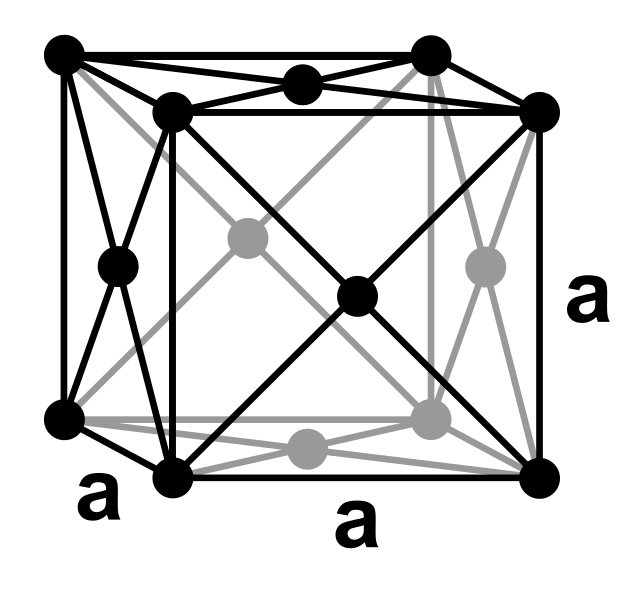

## Sample Answer

Let $\mathbb{I}$ be the inertia tensor of the cube in the body frame $\mathbf{b}$ fixed to the cube with the origin coinciding at the vertex that is pivoted. Let $\mathbf{b}=\mathbf{e}R$, $T^u$ be the representation of the control moments acting on the cube as expressed in the $\mathbf{b}=\mathbf{e}R$ frame, $l\,\gamma$ be the representation of the center of mass of the cube as expressed in the body frame $\mathbf{b}=\mathbf{e}R$ where $||\gamma||=1$ and $e_3=[0,0,1]^T$.

Then the equations of motion in the $\mathbf{e}$ frame are:


\begin{align}
\dot{R}&=\widehat{\omega}R,\\
\dot{\pi}&=-mgl\,(R\gamma\times e_3)+RT^u
\end{align} 
where $\pi=R\mathbb{I}\Omega=R\mathbb{I}R^T\omega$ 

In [ ]:
def externalForceModel(qq,parameters,X):
  #Heavy Top Object
  M=parameters['M']; II=parameters['II']; g=parameters['g']; CM=parameters['CM'];
  R=X[0][0]; omega=X[1]; spi=R@ II@ R.T @ omega
  fe=np.array([0,0,0]);
  taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1]);
  return [taue,fe]

def actuator(qq,parameters, t, X, taue,fe):
  tauu=np.array([0,0,0]);
  fu=np.array([0,0,0]);
  return [tauu,fu]

In [ ]:
mr=mugas_rigid_body_functions()

In [ ]:
M=10;l=2;w=1;h=4; II_1=M*(w**2+h**2)/12; II_2=M*(l**2+h**2)/12;II_3=M*(w**2+l**2)/12;
cubeDimensions={'l':l,'w':w,'h':h,'xp':l/2,'yp':w/2,'zp':h/2,}; #(x_p,y_p,z_p) - pivot point
parameters={'CM':np.array([l/2-cubeDimensions['xp'],w/2-cubeDimensions['yp'],h/2-cubeDimensions['zp']]), 'g':10, 'M':M, 'II':np.array([[II_1,0.,0.],[0.,II_2,0.],[0.,0.,II_3]])};
ICq=mr.qFromAxisAngles(0*np.pi/18,np.array([1,0,0])); ICR=mr.RfromQuaternions(ICq);
ICOmega=np.array([0.5,0.5,10.]); ICo=np.array([0.,0.,0.]); ICdoto=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],ICR@ICOmega,ICdoto,ICXC]

In [ ]:
aa4=mr.simulating_a_cube(0.1, 20., cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(aa4,'Cube Pivoted at a point')

# Q#3 Modeling the motion of a MRUAV

Considering the schematic of the quad-rotor UAV shown below write down the force model of the system and animate the motion of the quadrotor using the Python methods developed in Q#1.

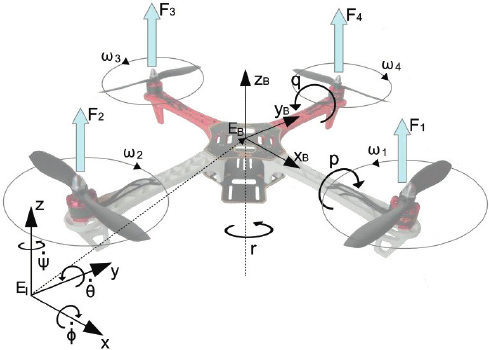

# Q#4 Modeling the motion of a ROV

Considering the model of an ROV shown below write down the force model of the system and animate the motion of the quadrotor using the Python methods developed in Q#1.

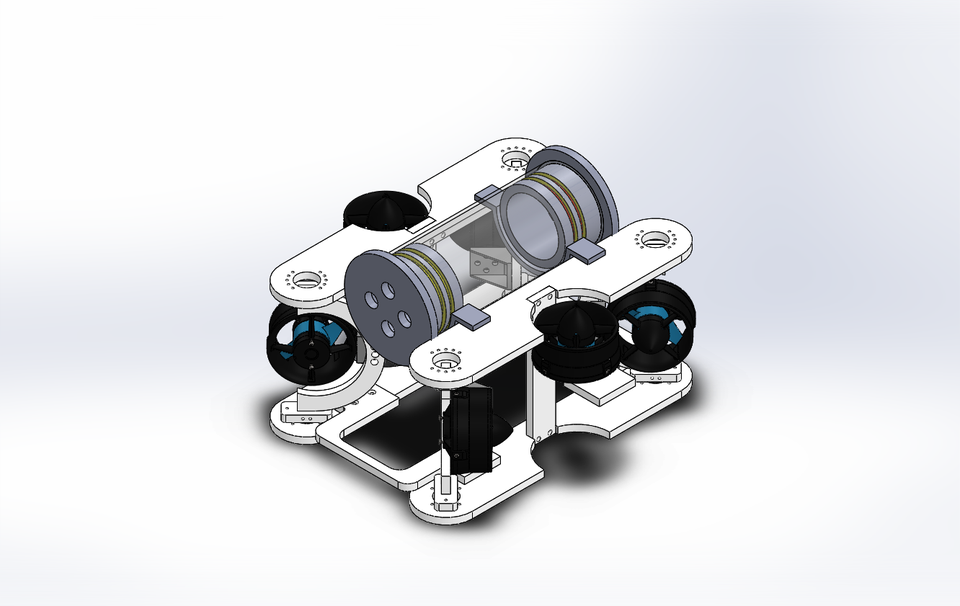

#Q#5 Free Rigid Body Motion

Consider a free rotating rigid body. That is a body where the resultant moments about the center of mass due to the external interactions is zero. We have seen that it is always possible to pick a body frame $\mathbf{b}$ such that the origin coincides with the center of mass of the body and the axis are aligned such that the resulting moment of inertia tensor $\mathbb{I}$ is diagonal. Thus, in what follows, without loss of generality we will consider $\mathbf{b}$ to be such a frame and answer the following questions: 

## Q#5.1

Show that the Kinetic Energy $\mathrm{KE}=\frac{1}{2}\mathbb{I}\Omega \cdot \Omega$, the spatial angular momentum, $\pi$, and the magnitude of the body angular momentum, $||\Pi||$, are conserved during the motion of the body.

## Q#5.2

Show that the free rigid body equations take the form:
\begin{align}
\dot{R} & = & R \;\widehat{\mathbb{I}^{-1}\Pi},\\
\dot{\Pi} & = & \Pi \times \mathbb{I}^{-1}\Pi.
\end{align}
In a frame $\mathbf{b}$ where the inertia tensor $\mathbb{I}$ is diagonal we have seen that these equations take the form
\begin{align}
\dot{\Pi}_1 & =  \frac{(\mathbb{I}_2-\mathbb{I}_3)}{\mathbb{I}_2 \mathbb{I}_3}\Pi_2 \Pi_3,\\
\dot{\Pi}_2 & =  \frac{(\mathbb{I}_3-\mathbb{I}_1)}{\mathbb{I}_3 \mathbb{I}_1}\Pi_3 \Pi_1,\\
\dot{\Pi}_3 & =  \frac{(\mathbb{I}_1-\mathbb{I}_2)}{\mathbb{I}_1 \mathbb{I}_2}\Pi_1 \Pi_2.
\end{align}
Here $\mathbb{I}=\mathrm{diag}\{\mathbb{I}_1,\mathbb{I}_2,\mathbb{I}_3\}$ and $\Pi=\begin{bmatrix}\Pi_1 & \Pi_2 &\Pi_3 \end{bmatrix}^T$.

## Q#5.3

Show that the solutions of $\dot{\Pi}=\Pi\times \mathbb{I}\Pi^{-1}$ correspond to the intersection curves of the corresponding angular momentum sphere, $||\Pi(t)||=\mathrm{constant}$, with the kinetic energy ellipsoid $\frac{1}{2}\Pi\cdot \mathbb{I}^{-1}\Pi=\mathrm{constant}$. Hence show that solutions $\Pi(t)$ are periodic in time.

## Q#5.4

Show that $\bar{\Pi}(t)\equiv \mu_1\triangleq h [1\:\:0\:\:0]^T$, $\bar{\Pi}(t)\equiv \mu_2\triangleq h [0\:\:1\:\:0]^T$, and $\bar{\Pi}(t)\equiv \mu_3\triangleq h [0\:\:0\:\:1]^T$ where $h=||\Pi||$ are equilibrium solutions of the rigid body equations $\dot{\Pi}=\Pi\times \mathbb{I}^{-1} \Pi$.

## Q#5.5

Let $\mu\triangleq \pi(t)$ denote the value of the constant spatial angular momentum of the body and  $\tau$ be the periodicity of the solution in $\Pi$ space. 

* Show that
\begin{align}
R(\tau)R^T(0)=\exp{\left(\theta\widehat{n}\right)}
\end{align}
where $n=\mu/||\mu||$. The rotation angle $\theta$ of $R(\tau)R^T(0)$ about $\mu$ is called the *phase* of the rotation.

* Explain the physical significance of this result.


## Q#5.6

Show that the angle between the angular velocity and the constant angular momentum remains constant through out the motion. That is show that
\begin{align}
\mu\cdot \omega(t)=\mathrm{constant}.
\end{align}

## Q#5.7

Let $\Upsilon$ be some such body fixed direction. For instance it could be the third principle direction of the body. We are interested in visualizing how the body moves with respect to the fixed spatial angular momentum direction. That is we would like to know how $R\Upsilon$ is related to $\mu=\pi$. Show that the angle that the body fixed $\Upsilon$ axis of the rigid 
body makes with the constant spatial angular momentum is given by  
\begin{align}
\alpha(t)=\mathrm{cos}^{-1}\left(\frac{\Upsilon \cdot \Pi}{||\Pi||}\right).
\end{align}
This angle is defined as the *angle of nutation* of the axis $\Upsilon$.

## Q#5.8

Show the following:

* For a perfectly spherical object,  $\mathbb{I}_1=\mathbb{I}_2=\mathbb{I}_3$ all trajectories correspond to steady rotations about some axis. 

* For a body sych that $\mathbb{I}_1>\mathbb{I}_2=\mathbb{I}_3$, as in the case of an axi-symmetric object such as a disk, show that there exists two isolated relative equilibrium along the major axis and a continuum of relative equilibria coinciding with the minor circle of the energy ellipsoid. Also show that the two isolated relative equilibria are stable while the ones along the minor axis are all unstable. 

* Show that the same conclusions as above apply for a thin cylinder type axi-symmetric objects where $\mathbb{I}_1=\mathbb{I}_2>\mathbb{I}_3$.

## Q#5.9 Axi-Symmetric Rigid Body

Consider a axi-symmetric object. That is a body where $\mathbb{I}_1=\mathbb{I}_2\neq \mathbb{I}_3$.

Show that when $\mathbb{I}_1=\mathbb{I}_2> \mathbb{I}_3$
\begin{align}
\Pi_1(t) &=\sqrt{\frac{\mathbb{I}_1(h-2E\mathbb{I}_3)}{\mathbb{I}_1-\mathbb{I}_3}}\cos(\omega_n\, t +c),\\
\Pi_2(t) &=\sqrt{\frac{\mathbb{I}_2(h-2E\mathbb{I}_3)}{(\mathbb{I}_2-\mathbb{I}_3)}}\;\sin(\omega_n\, t +c),\\
\Pi_3(t) &=\sqrt{\frac{\mathbb{I}_3(2E\mathbb{I}_1-h)}{\mathbb{I}_1-\mathbb{I}_3}}=\mathrm{constant}.
\end{align}
where $c$ is some constant, $E=\frac{1}{2}\mathbb{I}\Omega \cdot \Omega$,  $h=||\Pi(t)||$ and
\begin{align}
\omega_n=\sqrt{\frac{(2E\mathbb{I}_1-h)(\mathbb{I}_2-\mathbb{I}_3)}{\mathbb{I}_1\mathbb{I}_2\mathbb{I}_3}}=
\frac{(\mathbb{I}_1-\mathbb{I}_3)}{\mathbb{I}_1}\Omega_3.
\end{align}

## Q#5.10

Using Python develop an animation that demonstrates the behavior shown in https://youtu.be/1n-HMSCDYtM and use it to verify the counclusions made in Q#5.4 - Q#5.9.

### Defining the parameters

In [4]:
M=10;l=4.;w=1.;h=5; II_1=M*(w**2+h**2)/12; II_2=M*(l**2+h**2)/12;II_3=M*(w**2+l**2)/12;
cubeDimensions={'l':l,'w':w,'h':h,'xp':l/2,'yp':w/2,'zp':h/2,};
parameters={'CM':np.array([l/2-cubeDimensions['xp'],w/2-cubeDimensions['yp'],h/2-cubeDimensions['zp']]), 'g':10, 'M':M, 'II':np.array([[II_1,0.,0.],[0.,II_2,0.],[0.,0.,II_3]])};

In [5]:
II_1, II_2, II_3

(21.666666666666668, 34.166666666666664, 14.166666666666666)

### Definig the initial conditions

In [6]:
ICq=mr.qFromAxisAngles(0*np.pi/18,np.array([1,0,0])); ICR=mr.RfromQuaternions(ICq);
ICOmega=np.array([2.,-2.,10.]); ICo=np.array([0.,0.,0.]); ICdoto=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],ICR@ICOmega,ICdoto,ICXC]

### Simulating the dynamics

#### Defining the force model

In [7]:
def externalForceModel(qq,parameters,X):
  #Heavy Top Object
  M=parameters['M']; II=parameters['II']; g=parameters['g']; CM=parameters['CM'];
  R=X[0][0]; omega=X[1]; spi=R@ II@ R.T @ omega
  fe=np.array([0,0,0]);
  taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1]);
  return [taue,fe]

def actuator(qq,parameters, t, X, taue,fe):
  tauu=np.array([0,0,0]);
  fu=np.array([0,0,0]);
  return [tauu,fu]

#### Simulating the dynamics

In [8]:
dt=0.01; Tmax=10.;
aa4=mr.simulating_a_cube(dt, Tmax, cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(aa4,'Cube Pivoted at a point')

### Plotting the intersection of the Angular Momentum sphere with the Kinetic Energy ellipsoid

In [ ]:
II=np.array([[3.8,0,0],[0,2.5,0],[0,0,0.5]]); #parameters['II']; 
magPi=linalg.norm(II@ICOmega);
KE=0.5*ICOmega.T@II@ICOmega;
spatialpi=ICR@II@ICOmega;

In [ ]:
II

array([[3.8, 0. , 0. ],
       [0. , 2.5, 0. ],
       [0. , 0. , 0.5]])

In [ ]:
dphi, dtheta = np.pi / 25.0, np.pi / 25.0
[phi, theta] = np.mgrid[0:np.pi + dphi * 1.5:dphi, 0:2 * np.pi +
                        dtheta * 1.5:dtheta]
m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r=magPi;  a=np.sqrt(2*KE*II[0,0]); b=np.sqrt(2*KE*II[1,1]); c=np.sqrt(2*KE*II[2,2]);# a=2.38047614284762; b=2.58198889747161; c=1.29099444873581; # 
# Applying the parametric equation..
#r = (np.sin(m0 * phi) ** m1 + np.cos(m2 * phi) ** m3 + np.sin(m4 * theta) ** m5 + np.cos(m6 * theta) ** m7)
x1 = r * np.sin(phi) * np.cos(theta); z1 = r * np.cos(phi); y1 = r * np.sin(phi) * np.sin(theta)
x2 = a * np.sin(phi) * np.cos(theta); z2 = c * np.cos(phi); y2 = b * np.sin(phi) * np.sin(theta)


surface1 = go.Surface(x=x1, y=y1, z=z1, colorscale='Viridis')
surface2 = go.Surface(x=x2, y=y2, z=z2, colorscale='Viridis')
data = [surface1,surface2]
layout = go.Layout(
    title='Intersection of the angular momentum sphere and the Kinetic Energy Ellipsoid',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
fig.show()

### Plotting the nutation angle

In [ ]:
Xs=mr.runga_kutta_method(dt,Tmax,parameters,ICs);

In [ ]:
II=parameters['II']; 

In [ ]:
alphat=[];
for X in Xs:
  R=X[0][0];
  Pi=R@II@R.T@X[1];
  alphat+=[round(math.acos(Pi[2]/linalg.norm(Pi)), 5)]
t=np.linspace(0,Tmax+dt,round(Tmax/dt)+2)

In [ ]:
fig = go.Figure(data=go.Scatter(x=t, y=alphat, mode='markers'))
fig.show()